# Exploratory data analysis

### Module loading

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re

### Ideas

* Include a feature that captures if more people were in the cabin for instance

## Data loading

In [3]:
data = pd.read_csv("raw_data/train.csv")

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature analysis

First, lets look at the initial features

### Passenger ID

In [28]:
data.PassengerId.describe()

count     891
unique    891
top       891
freq        1
Name: PassengerId, dtype: int64

In [26]:
# Check if all the passengerIds are unique
data["PassengerId"].value_counts().value_counts()

1    891
Name: PassengerId, dtype: int64

All passenger Ids are unique.

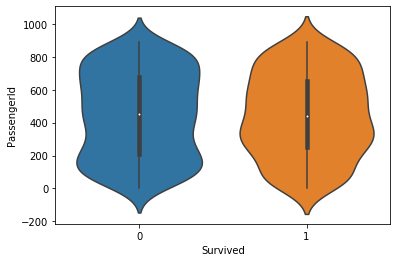

In [23]:
# Check if there is any relationship between survival and passenger IDs
sns.violinplot(x="Survived", y="PassengerId", data=data)
plt.show()

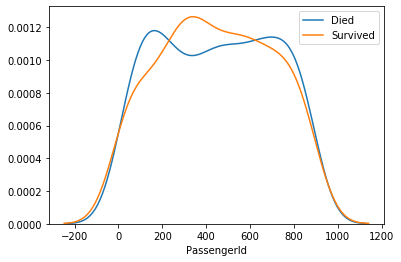

In [25]:
sns.distplot(data.PassengerId[data.Survived == 0], hist = False, label = "Died")
sns.distplot(data.PassengerId[data.Survived == 1], hist = False, label = "Survived")
plt.show()

In general it seems that there is no tendency relating passenger ID with survival

### Survived

In [9]:
data.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

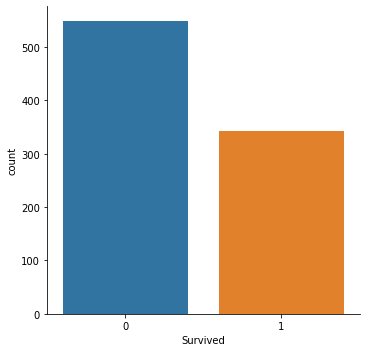

In [24]:
sns.catplot(x="Survived", kind="count", data=data)
plt.show()

Aproximately a 60% of the passengers died in the titanic and 40% survived. Probably the dataset is balanced enough to not include weights in the model.

### Pclass

In [16]:
data.Pclass.value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

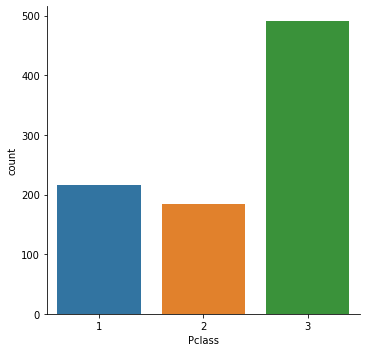

In [13]:
sns.catplot("Pclass", data = data, kind="count")

Passenger class is not balanced, 55% of the people where 3rd class, the rest is similarly balanced between 1st and 2nd class. 

In [18]:
data.groupby("Pclass").Survived.value_counts(normalize=True)

Pclass  Survived
1       1           0.629630
        0           0.370370
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
Name: Survived, dtype: float64

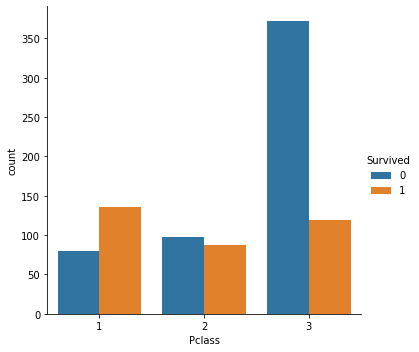

In [12]:
sns.catplot("Pclass", data = data, hue="Survived", kind="count", )

The frequency of survival is highly dependent on the passenger class. While in 3rd class people had 75% chances of dying, in 2nd it is a 52% and in 1st it is only a 37% chances. Therefore, The higher the class the more chances to survive.

### Name
Although there is some usefull information in the name field we will process this field later in the notebook. First, I will try to set a baseline using the simplest features in the initial dataset. 

### Sex

In [23]:
data.Sex.value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

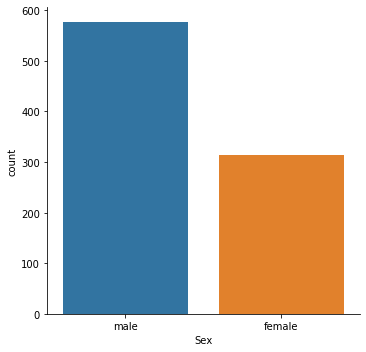

In [24]:
sns.catplot("Sex", data = data, kind="count")

Regarding Sex, 64% of the passengers where males.

In [25]:
data.groupby("Sex").Survived.value_counts(normalize=True)

Sex     Survived
female  1           0.742038
        0           0.257962
male    0           0.811092
        1           0.188908
Name: Survived, dtype: float64

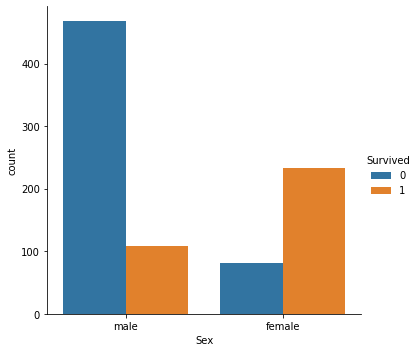

In [26]:
sns.catplot("Sex", data = data, hue="Survived", kind="count", )

Again, the survival rate is quite different between the two clases. A woman had 74% chances of surviving, while mens had 81% chances of perishing. It seems that class and sex are going to be quite important in predicting survival. Let's see if there is any kind of interaction between the two features. 

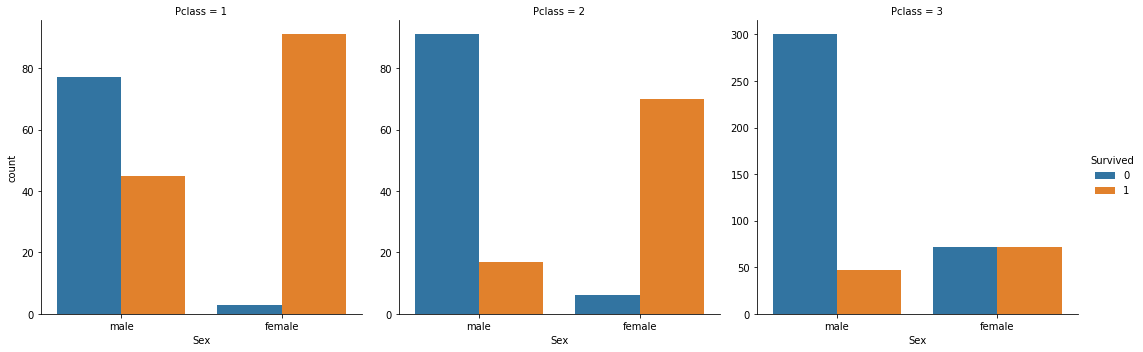

In [38]:
sns.catplot(x="Sex",col="Pclass", hue="Survived", kind="count", data = data, sharey=False)

It is evident that there is some interaction between the two variables. While being a woman of 1st or 2nd class  practically enures survival, womens of the 3rd class had the same chances of dying than surviving. Regarding men, survival rate is similar between males of 3rd and 2nd class. However, the forecast improves in 1st class men. 

### Age

In [43]:
data.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

There is 177 (891-714) Passengers without age information. Mmaybe we can try to inputate the age based on closest neightbours. 

In [44]:
data.Age[data.Age < 1]

78     0.83
305    0.92
469    0.75
644    0.75
755    0.67
803    0.42
831    0.83
Name: Age, dtype: float64

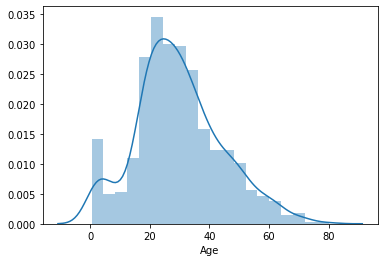

In [41]:
sns.distplot(data.Age.dropna())

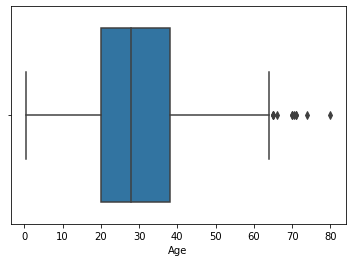

In [46]:
sns.boxplot("Age", data = data)

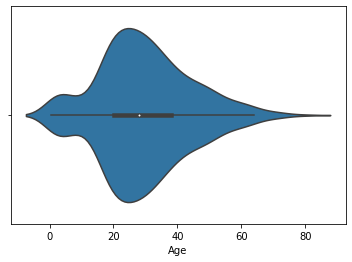

In [49]:
sns.violinplot("Age", data = data)

The distribution of age has a bell shape squed to the right. Also there is a small peak of frequency in babies that do not follow this bellshape. Some of the passengers fall out of the IQR, They are probably good candidates for outliers removal. 

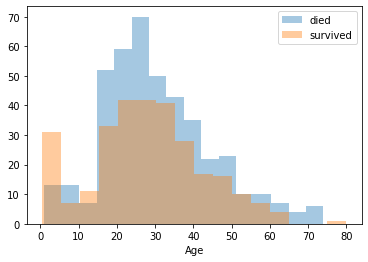

In [58]:
sns.distplot(data.Age[data.Survived == 0].dropna(), kde = False, label="died")
sns.distplot(data.Age[data.Survived == 1].dropna(), kde = False, label="survived")
plt.legend()

By looking at the distribution of Age between survivors and non-survivors it seems that Age is also important in terms of survival. Kids from 0 to 5 years are the ones with more chance of surviving. Old people from 65 to 75 have less chances of survival, however, low numbers in this range makes this data of less informative. After this group, people between 15 and 30 have more chances of diying. The rest of people have slightly more chances of dying but being close to 50-50 situation

### SibSp

In [61]:
data.SibSp.describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

In [65]:
data.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

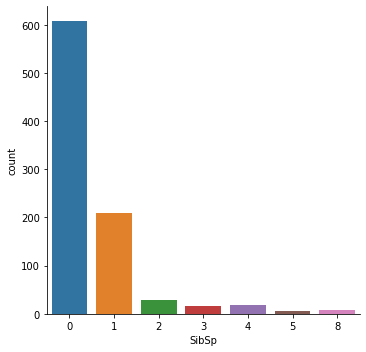

In [64]:
sns.catplot("SibSp", kind="count", data=data)

Almost all the people have either 0 or 1 sibling or spoutse on board. Only a few people had 2 or more. This low numbers could add some noice to our model. We could consider bucketizing categoires from 2 to 8 in a single one in order to capture common features between this group with some statistical confidence.

In [73]:
data.groupby("SibSp")["Survived"].value_counts(normalize=True)

SibSp  Survived
0      0           0.654605
       1           0.345395
1      1           0.535885
       0           0.464115
2      0           0.535714
       1           0.464286
3      0           0.750000
       1           0.250000
4      0           0.833333
       1           0.166667
5      0           1.000000
8      0           1.000000
Name: Survived, dtype: float64

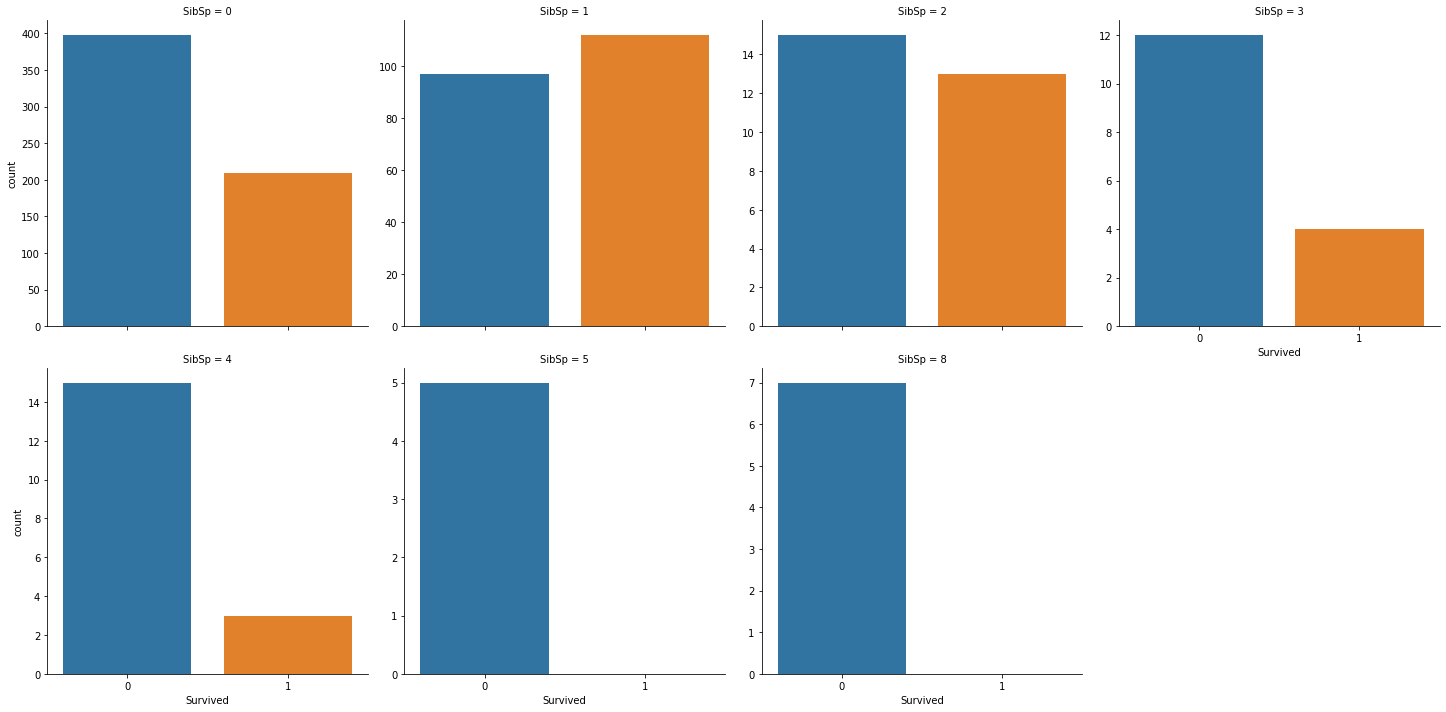

In [74]:
sns.catplot("Survived", kind="count",col="SibSp",col_wrap=4, sharey = False, data=data)

It seems that having 1 or 2 spouse and or siblings increse survival chances in comparison with other groups. All the people with 5 or more spouse+siblings died, however lets keep in mind the low N of this groups. for the other groups survival rates range from 16 in the case of 4% sibsp to 34% in the case of 0

### Ticket
For the same reason than the name, I will leave ticket for later

### Fare
Probably, Fare will be quite correlated to class. Therefore we may want to keep only one of the two features for modeling

In [75]:
data.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

There is no Nan in this feature, however, the minimal value is 0. This can be due to represent not available data as 0 and for the members of the crew.

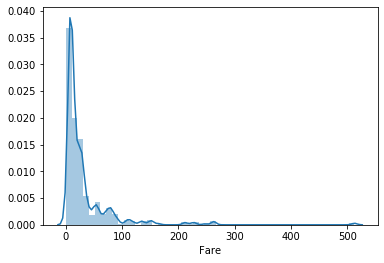

In [76]:
sns.distplot(data.Fare)

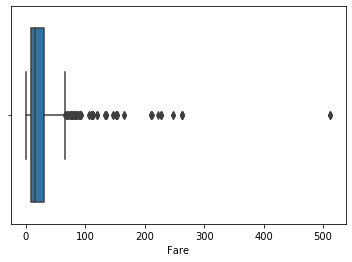

In [77]:
sns.boxplot("Fare", data = data)

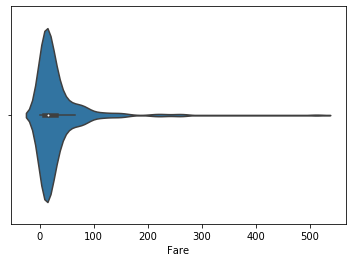

In [78]:
sns.violinplot("Fare", data = data)

The distribution of age has a bell shape squed to the right. Also there is a small peak of frequency in babies that do not follow this bellshape. Some of the passengers fall out of the IQR, They are probably good candidates for outliers removal. 

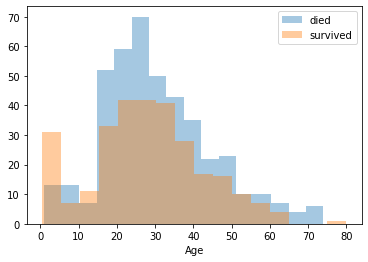

In [58]:
sns.distplot(data.Age[data.Survived == 0].dropna(), kde = False, label="died")
sns.distplot(data.Age[data.Survived == 1].dropna(), kde = False, label="survived")
plt.legend()

By looking at the distribution of Age between survivors and non-survivors it seems that Age is also important in terms of survival. Kids from 0 to 5 years are the ones with more chance of surviving. Old people from 65 to 75 have less chances of survival, however, low numbers in this range makes this data of less informative. After this group, people between 15 and 30 have more chances of diying. The rest of people have slightly more chances of dying but being close to 50-50 situation

## Feature Engineering

### Name

In [6]:
# Extracting the family name
data["family_name"] = data.Name.apply(lambda x: re.findall("(.*),", x)[0])

In [15]:
# Extracting title
data["title"] = data.Name.apply(lambda x: re.findall("(\w*)\.", x)[0])

In [8]:
# Extracting text between parenthesis
parenthesis = data.Name.apply(lambda x: re.findall("\((.*)\)", x))
data["parenthesis"] = parenthesis.apply(lambda x: x[0] if x else np.nan)

In [19]:
# extracting the given name
given_name = data.Name.apply(lambda x: re.findall("\. (.+?)( \(|$)", x))
data["given_name"] = given_name.apply(lambda x: x[0][0] if x else np.nan)

In [20]:
# cuotes

cuotes = data.Name.apply(lambda x: re.findall('\"(.*)\"', x))
data["cuotes"] = cuotes.apply(lambda x: x[0] if x else np.nan)